<a href="https://colab.research.google.com/github/YonDraco/learn-deep-learning/blob/main/VAE_MNIST_Coursera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders

Bộ mã tự động biến thể (VAE) được đào tạo trên tập dữ liệu MNIST và xem cách nó có thể tạo hình ảnh mới.

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

## Parameters

In [ ]:
# Xác định các hằng số toàn cục
BATCH_SIZE=128
LATENT_DIM=2

## Prepare the Dataset

Chỉ sử dụng phần đã tách `train`. 

* `map_image()` - chuẩn hóa và tạo ra một tensor từ hình ảnh, chỉ trả lại hình ảnh. Điều này sẽ được sử dụng cho việc học tập không có giám sát trong trình mã tự động.

* `get_dataset()` - tải MNIST từ dataset Tensorflow, tìm phần tách `train` theo mặc định, sau đó chuẩn bị nó bằng cách sử dụng chức năng ánh xạ. Nếu `is_validation` được đặt thành` True`, thì thay vào đó nó sẽ nhận được phần tách `test`. Các tập huấn luyện cũng sẽ được xáo trộn.

In [ ]:
def map_image(image, label):
  '''trả về một tensor chuẩn hóa và được định hình lại từ một hình ảnh nhất định'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))
  
  return image


def get_dataset(map_fn, is_validation=False):
  '''Loads and chuẩn bị mnist dataset từ TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)
  
  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

Chạy và tải tập tách data `train` từ MNIST dataset.

In [ ]:
train_dataset = get_dataset(map_image)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

VAE model

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

VAE cũng có kiến ​​trúc bộ mã hóa-giải mã với sự khác biệt chính là hộp màu xám ở giữa, đại diện cho biểu diễn tiềm ẩn. Trong lớp này, mô hình trộn một mẫu ngẫu nhiên và kết hợp nó với các đầu ra của bộ mã hóa. Cơ chế này làm cho nó hữu ích cho việc tạo nội dung mới.

### Sampling Class

Đầu tiên, xây dựng lớp Lấy mẫu. Đây sẽ là một lớp Keras tùy chỉnh sẽ cung cấp đầu vào nhiễu Gaussian cùng với giá trị trung bình (mu) và độ lệch chuẩn (sigma) của đầu ra của bộ mã hóa. Trong thực tế, đầu ra của lớp này được cho bởi phương trình:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

Với $\mu$ = giá trị trung bình, $\sigma$ = độ lệch chuẩn, và $\epsilon$ = random sample

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Tạo một mẫu ngẫu nhiên và kết hợp với đầu ra của bộ mã hóa
    
    Args:
      inputs -- output tensor từ encoder

    Returns:
      `inputs` tensors kết hợp với random sample
    """

    # giải nén đầu ra của bộ mã hóa
    mu, sigma = inputs

    # lấy size and kích thước của batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # tạo ra một tensor ngẫu nhiên
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    # kết hợp các đầu vào và noise
    return mu + tf.exp(0.5 * sigma) * epsilon

### Encoder

Ngoài mu và sigma, bạn cũng sẽ xuất ra hình dạng của các đối tượng trước khi làm phẳng nó. Điều này sẽ hữu ích khi tái tạo lại hình ảnh sau này trong bộ giải mã..

*Note:* có thể gặp phải sự cố khi sử dụng chuẩn hóa hàng loạt với các batch nhỏ hơn và đôi khi lời khuyên được đưa ra là tránh sử dụng chuẩn hóa hàng loạt khi huấn luyện VAE nói riêng.

<img src="https://drive.google.com/uc?export=view&id=1eoxFK_UVSHd3a_5EHcCU8F8QDZlPiXfW" width="60%" height="60%"/>

In [ ]:
def encoder_layers(inputs, latent_dim):
  """xác định encoder's layers.
  Args:
    inputs -- batch dataset
    latent_dim -- chiều của không gian ẩn

  Returns:
    mu -- giá trị trung bình đã học 
    sigma -- độ lệch chuẩn đã học
    batch_2.shape -- shape của features trước flattening
  """

  # thêm Conv2D layers tiếp theo là BatchNormalization
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

  # gán cho một biến khác để bạn có thể trích xuất hình dạng sau này
  batch_2 = tf.keras.layers.BatchNormalization()(x)

  # flatten the features and feed into the Dense network
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  # sử dụng 20 unit
  x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # thêm output Dense networks cho mu và sigma, unit bằng với khai báo latent_dim.
  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_2.shape

Với các lớp bộ mã hóa được xác định, bạn có thể khai báo mô hình bộ mã hóa bao gồm `Sampling` 

In [ ]:
def encoder_model(latent_dim, input_shape):
  """xác định encoder model với Sampling layer
  Args:
    latent_dim -- chiều của không gian tiềm ẩn
    input_shape -- shape của dataset batch

  Returns:
    model -- encoder model
    conv_shape -- shape của features trước flattening
  """

  # khai báo tensor đầu vào với hình dạng đã cho
  inputs = tf.keras.layers.Input(shape=input_shape)

  # lấy output của hàm encoder_layers() 
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  # feed mu and sigma to the Sampling layer
  z = Sampling()((mu, sigma))

  # build the whole encoder model
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  return model, conv_shape

### Decoder

xây dựng phần giải mã của mạng mở rộng các biểu diễn tiềm ẩn trở lại kích thước hình ảnh ban đầu. Như bạn sẽ thấy ở phần sau trong vòng lặp đào tạo, bạn có thể cung cấp các đầu vào ngẫu nhiên cho mô hình này và nó sẽ tạo ra nội dung giống với dữ liệu đào tạo.

In [ ]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  
  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)
  
  return x

xác định mô hình bộ giải mã

In [ ]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)
  
  return model

### Kullback–Leibler Divergence

Để cải thiện khả năng sinh của mô hình, bạn phải tính đến phân phối chuẩn ngẫu nhiên được đưa vào trong không gian tiềm ẩn [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514). Công thức sau

In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss

### VAE Model

You can now define the entire VAE model. Note the use of `model.add_loss()` to add the KL reconstruction loss. Computing this loss doesn't use `y_true` and `y_pred` so it can't be used in `model.compile()`. 

In [ ]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)
  
  # get reconstructed output from the decoder
  reconstructed = decoder(z)

  # define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

để thiết lập và lấy các mô hình khác nhau từ các hàm mà bạn đã xác định

In [ ]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [ ]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

## Train the Model

You can now setup the VAE model for training. Let's start by defining the reconstruction loss, optimizer and metric.

In [ ]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

You will want to see the progress of the image generation at each epoch. For that, you can use the helper function below. This will generate 16 images in a 4x4 grid.

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

The training loop is shown below. This will display generated images each epoch and will take around 30 minutes to complete. Notice too that we add the KLD loss to the binary crossentropy loss before we get the gradients and update the weights.

As you might expect, the initial 16 images will look random but it will improve overtime as the network learns and you'll see images that resemble the MNIST dataset.

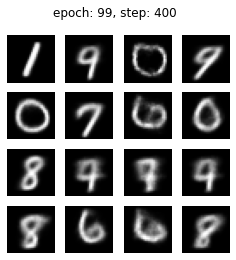

Epoch: 99 step: 400 mean loss = 142.91687


In [ ]:
# Training loop. 

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784
      
      # add KLD regularization loss
      loss += sum(vae.losses)  

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))